In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch import optim

In [20]:
from NLPfunctions import *
from NLPmodels import *
from NLPutils import *
from NLP_data_utils import *

In [3]:
from utils_DRD import get_repr_DTI

In [4]:
from data_tool_box_DRD import str2bool, load_pkl
# from DTI_meta_MAML_DRD import meta_DTI_MAML
from models_MAML import DTI_model_MAML

In [5]:
parser=argparse.ArgumentParser()
parser.add_argument('--frozen',default="none",type=str)
parser.add_argument('--cwd',default="../",type=str)
parser.add_argument('--batch_size',default=6,type=int)
parser.add_argument('--meta_lr',default=1e-3,type=float)
parser.add_argument('--global_MAML_step', default=20, type=int,
                    help='Number of global training steps, i.e. numberf of mini-batches ')
parser.add_argument('--val_range',default=26,type=int)
opt= parser.parse_args('')

In [6]:
args = {}
args.update(vars(opt))

In [7]:
# train = pd.read_csv('../data/train_tokenized.csv')
train = pd.read_pickle('../data/train_tokenized.pkl')
# test=pd.read_csv('../data/test_set.csv')

# assemble

In [21]:
V =15
padding_idx=0

In [10]:
model = DTI_model_MAML(all_config=args).to('cuda')

tokenizer = model.prot_tokenizer

In [12]:
criterion_smooth = LabelSmoothing(V,padding_idx,smoothing=0.0)

meta_optim = optim.Adam(model.parameters(), lr=args['meta_lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(meta_optim, T_max=10)

In [9]:
# criterion=nn.MSELoss(reduction='mean')
# loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
chem_dict = pd.Series(load_pkl( args['cwd']+'data/ChEMBLE26/chemical/ikey2smiles_ChEMBLE.pkl'))
protein_dict = pd.Series(load_pkl(args['cwd']+'data/ChEMBLE26/protein/unipfam2triplet.pkl'))


In [28]:
train_classic_performance = {'loss': [], 'overall': []}

# for step in range(args['global_MAML_step']):
for step in range(20):
    model.train()
    print(step)
#     batch = train.sample(args['batch_size'])
#     chem_graph, protein_tokenized = get_repr_DTI(batch, tokenizer, chem_dict, protein_dict, 'DISAE')
#     ---------------------
    batch = train.sample(args['batch_size'])
    chem_graph,protein_tokenized = get_repr_DTI(batch,tokenizer,chem_dict,protein_dict,'DISAE')

    out,ntokens,target = model.encode(protein_tokenized.to('cuda'),
                                     chem_graph.to('cuda'),
                                     batch)

    out_G = model.generator(out)
    loss = criterion_smooth(out_G.contiguous().view(-1,out_G.size(-1)),target.contiguous().view(-1))
    loss = loss/ntokens
    #     ---------------------
    meta_optim.zero_grad()
    loss.backward()
    meta_optim.step()
    scheduler.step()
    train_classic_performance['loss'].append(loss.detach().cpu().item())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# plot

In [29]:
import matplotlib.pyplot as plt

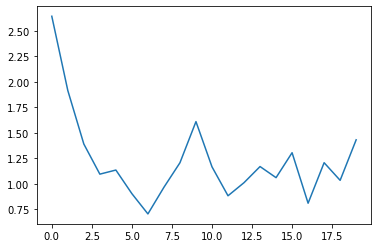

In [30]:
plt.plot(range(len(train_classic_performance['loss'])), train_classic_performance['loss'])

# encode

In [32]:
pad=0

In [30]:
src_embedding = model.src_embed(batch_protein_tokenized.to('cuda'),
                                batch_chem_graph.to('cuda'))

In [38]:
device = (src_embedding.device)

In [37]:
src_mask = torch.ones(src_embedding.size()[:2])
src_mask = (src_mask != pad).unsqueeze(-2).to(src_embedding.device)
m    = model.encoder(src_embedding, src_mask)

In [42]:
trg = torch.tensor(batch['token_id_mapped'].values.tolist())[:, :-1].to(device)
target = torch.tensor(batch['token_id_mapped'].values.tolist())[:, 1:].to(device)
trg_mask = make_std_mask(trg, pad).to(device)
ntokens = (trg != pad).data.sum()

# src_embed

In [19]:
batch_chem_graphs_repr_masked, batch_protein_repr= model.dti_embed(protein_tokenized.to('cuda'),chem_graph.to('cuda'))

In [24]:
batch_protein_tokenized = protein_tokenized
batch_chem_graph = chem_graph

In [20]:
prot_em_strech =model.strech(batch_protein_repr)

In [28]:
dti_cat = torch.cat([batch_chem_graphs_repr_masked,prot_em_strech],1)

In [29]:
src_embedding=model.strech2(dti_cat)

In [194]:
# inter_vec= model.encode(protein_tokenized.to('cuda'),chem_graph.to('cuda'))
# chem_em,prot_em= model.encode(protein_tokenized.to('cuda'),chem_graph.to('cuda'))
# chem_vector, prot_vector,chem_score,prot_score=


In [195]:
# inter_vec.shape
chem_em.shape,prot_em.shape
# chem_vector.shape, prot_vector.shape,chem_score.shape,prot_score.shape

(torch.Size([6, 33, 300]), torch.Size([6, 255, 312]))

In [200]:
stretch = nn.Linear(312,300).cuda()

In [216]:
stretch2 = nn.Linear(300,d_model).cuda()

In [202]:
prot_em_stretch =stretch(prot_em)

In [203]:
prot_em_stretch.shape

torch.Size([6, 255, 300])

In [217]:
V=len(token_map.keys())

h =8
d_model=512
d_ff=2048
dropout=0
src_vocab= 288
tgt_vocab=V
N =2


pad =0
prot_em_strech=strech(batch_protein_repr)
dti_cat= torch.cat([chem_em,prot_em_stretch],1)

In [321]:
len(token_map.keys())

15

In [220]:
src_embedding = stretch2(dti_cat)

In [222]:
src_embedding.shape

torch.Size([6, 288, 512])

# encoder

In [47]:
# V=len(token_map.keys())
V = 15
h =8
d_model=512
d_ff=2048
dropout=0
src_vocab= 288
tgt_vocab=V
N =2


pad =0

In [224]:
encoder_layer= EncoderLayer(d_model, c(attn), c(ff),dropout)
encoder = Encoder(encoder_layer,N).cuda()
# src_embed= nn.Sequential(Embeddings(d_model,src_vocab),c(position))

In [225]:

# src_mask = torch.ones(memory.size()[:2])
src_mask = torch.ones(src_embedding.size()[:2])

src_mask = (src_mask!=pad).unsqueeze(-2).cuda()

In [228]:
# memory.shape,
src_mask.shape,src_embedding.shape

(torch.Size([6, 1, 288]), torch.Size([6, 288, 512]))

In [229]:
m_memory=encoder(src_embedding,src_mask)

In [230]:
m_memory.shape

torch.Size([6, 288, 512])

# decoder

In [39]:
import pickle
import numpy as np
from torch.autograd import Variable

In [40]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask



In [85]:
with open('../data/tokenizer.pkl','rb') as f:
    token_map = pickle.load(f)

In [86]:
token_map

{'<pad>': 0,
 '+': 1,
 '-': 2,
 'e': 3,
 '.': 4,
 '0': 5,
 '1': 6,
 '2': 7,
 '3': 8,
 '4': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '8': 13,
 '9': 14}

In [246]:
trg = torch.tensor(batch['token_id_mapped'].values.tolist())[:,:-1].cuda()

In [247]:
target = torch.tensor(batch['token_id_mapped'].values.tolist())[:,1:].cuda()

In [89]:
# trg_mask = (trg!=pad).unsqueeze(-2)

In [248]:
trg_mask =make_std_mask(trg,pad)


In [48]:
attn = MultiHeadedAttention(h,d_model)
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
position=PositionalEncoding(d_model,dropout)
c = copy.deepcopy
# 0------------------------------
decoder_layer = DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout).cuda()
decoder= Decoder(decoder_layer,N).cuda()
tgt_embed = nn.Sequential(Embeddings(d_model,tgt_vocab),c(position)).cuda()
generator = Generator(d_model,tgt_vocab).cuda()

In [117]:
# memory = inter_vec

In [49]:
tgt_embedding = tgt_embed(trg)

In [250]:
tgt_embedding.shape,trg.shape

(torch.Size([6, 21, 512]), torch.Size([6, 21]))

In [51]:
out = decoder(tgt_embedding,src_embedding,src_mask,trg_mask)

In [52]:
out.shape

torch.Size([6, 21, 512])

# dissect decoder

In [134]:
size = d_model
self_attn = c(attn).cuda()
src_attn = c(attn).cuda()
feed_forward=ff.cuda()
dropout=dropout

In [251]:
tgt_mask = trg_mask

In [252]:
ntokens  = (trg!=pad).data.sum()

In [253]:
sublayer= clones(SublayerConnection(size,dropout),3).cuda()

In [254]:
# m=memory.unsqueeze(1)
# m = m.repeat(1,22,1)
m = m_memory

In [255]:
x = tgt_embedding

In [256]:
x1 = sublayer[0](x, lambda x: self_attn(x,x,x,tgt_mask))

In [257]:
x1.shape,m.shape,src_mask.shape

(torch.Size([6, 21, 512]), torch.Size([6, 288, 512]), torch.Size([6, 1, 288]))

In [258]:
x2 = sublayer[1](x1, lambda x1: src_attn(x,m,m,src_mask))

In [259]:
x2.shape

torch.Size([6, 21, 512])

# dissect loss

In [235]:
criterion = nn.KLDivLoss(size_average=False)

In [276]:
size = 22

In [285]:
padding_idx=pad

In [245]:
pad

0

In [277]:
true_dist= x2.data.clone()

In [278]:
true_dist.shape

torch.Size([6, 21, 512])

In [265]:
smoothing =0.0

In [266]:
confidence=1.0-smoothing

In [269]:
true_dist.shape

torch.Size([6, 21, 512])

In [279]:
true_dist.fill_(smoothing/(size-2))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

In [280]:
true_dist.shape

torch.Size([6, 21, 512])

In [281]:
true_dist.scatter_(1, target.data.unsqueeze(1), confidence)

tensor([[[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

In [282]:
true_dist.shape

torch.Size([6, 21, 512])

In [286]:
true_dist[:, padding_idx] = 0

In [292]:
mask = torch.nonzero(target.data==pad).cuda()

In [293]:
mask.shape

torch.Size([67, 2])

In [294]:
mask.squeeze().shape

torch.Size([67, 2])

# use loss

In [318]:
criterion_smooth = LabelSmoothing(V,padding_idx,smoothing=0.0)

In [314]:
size

22

In [305]:
generator = Generator(d_model,tgt_vocab).cuda()

In [306]:
out_G = generator(x2)

In [308]:
out_G.shape,target.shape

(torch.Size([6, 21, 15]), torch.Size([6, 21]))

In [311]:
norm = ntokens

In [317]:
out_G.contiguous().view(-1,out_G.size(-1)).shape

torch.Size([126, 15])

In [319]:
criterion_smooth(out_G.contiguous().view(-1,out_G.size(-1)),target.contiguous().view(-1))

tensor(1015.4486, device='cuda:0', grad_fn=<KlDivBackward>)

# greedy decode

In [242]:
ys = torch.ones(1,1).fill_(99).type_as(trg.data)

In [243]:
ys

tensor([[99]], device='cuda:0')

In [240]:
ys.shape

torch.Size([1, 1])

In [244]:
subsequent_mask(ys.size(1))

tensor([[[True]]])